# Introduction

_Zalay, O., Bontempi, D., Bitterman, D. S., et Al. - Deep learning estimates of biological age from face photographs predict clinical outcomes_.

This notebook allows the user to understand how to run the FaceAge pipeline (i.e., how is the pipeline set-up, how to format the input, and what to expect as the output), as well as estimate the computational costs of the operation involved.

**Note: the following cell is temporary, and will be updated upon publication.**

The updated version will handle the download of the data shared on [Zenodo](https://zenodo.org), so that this notebook will be freely executable by everyone.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

PROJECT_PATH = "/content/gdrive/MyDrive/AIM/Projects/FaceAge"

Mounted at /content/gdrive


---


# Pipeline Description

The only dependency we need to install to run the FaceAge pipeline is the MTCNN face detector. All the other packages are already available on a standard Google Colab instance (and supported by the pipeline).

In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 33.8 MB/s 


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sys
import time
import platform

import gc
import PIL
import mtcnn
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import clear_output

from skimage.io import imsave, imread

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
#%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'svg'

sns.set_style(style = "whitegrid",
              rc = {"font.family": "serif",
                    "font.serif": "Times New Roman"})

Let us check the version of all the packages used in the pipeline, as well as the operating system, the CUDA and CuDNN libraries:

In [ ]:
print(platform.platform())

print("\nPython version     : ", sys.version.split('\n')[0])
print("TensorFlow version : ", tf.__version__)
print("Keras version      : ", keras.__version__)
print("Numpy version      : ", np.__version__)
print("MTCNN version      : ", mtcnn.__version__)

Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic

Python version     :  3.7.12 (default, Sep 10 2021, 00:21:48) 
TensorFlow version :  2.7.0
Keras version      :  2.7.0
Numpy version      :  1.19.5
MTCNN version      :  0.1.0


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!cat $(whereis "cudnn.h") | grep CUDNN_MAJOR -A 2

cat: 'cudnn:': No such file or directory
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 6
#define CUDNN_PATCHLEVEL 5
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


In [ ]:
!nvidia-smi

Wed Jan 19 09:43:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
BASE_DATA_PATH = os.path.join(PROJECT_PATH, "data")
BASE_MODEL_PATH = os.path.join(PROJECT_PATH, "models")

# save the output CSV in a folder parsable by the data_viz notebook
BASE_OUTPUT_PATH = os.path.join(PROJECT_PATH, "outputs")

---

# Data Processing

The pipeline is divided in two steps:
1. **Face Localization** - first, given an input image containing a subject (whose face is visible), a bounding box around the face is computed (by the MTCNN face detector). This allows the input to the apparent age estimation network to be somewhat standardised (e.g., although perspective can change, it will contain only one face, background will be mostly excluded, etc.);
2. **FaceAge Estimation** - second, after the face of the subject has been located, we can use the FaceAge network we trained to estimate the apparent age of the subject. The output of this network, whose architectural and training details are provided in the manuscript and in the GitHub repository, is the quantity we use across all the study.

## Face Localization

The first step of the FaceAge pipeline consists in localizing the face of the subject in the input image. To do so, we exploit a freely available, open-source implementation of the MTCNN face detector.

From the [MTCNN library GitHub page](https://github.com/ipazc/mtcnn):

> The detector returns a list of JSON objects. Each JSON object contains three main keys: 'box', 'confidence' and 'keypoints':

> The bounding box is formatted as [x, y, width, height] under the key 'box'.
The confidence is the probability for a bounding box to be matching a face.
The keypoints are formatted into a JSON object with the keys 'left_eye', 'right_eye', 'nose', 'mouth_left', 'mouth_right'. Each keypoint is identified by a pixel position (x, y).

In [ ]:
def get_face_bbox_from_image(path_to_image):
  
  # sanity check
  assert os.path.exists(path_to_image)

  pat_img = imread(path_to_image)
  
  try:
    return mtcnn.mtcnn.MTCNN().detect_faces(pat_img)[0]
  except:
    # patient
    print('ERROR: Processing error for file "%s"'%(path_to_image))
    return dict()

In [ ]:
input_base_path = os.path.join(BASE_DATA_PATH, "utk_hi-res_qa")

input_file_list = [f for f in os.listdir(input_base_path) if ".png" in f or ".jpg" in f]

In this example, all the files in the input folder at `input_base_path` are `.jpg` files.

However, the input folder can contain files that are not `.png` or `.jpg`, as only these formats will be read and processed. Here follows an example of how a folder should look like:

```
$BASE_DATA_PATH
└── utk_hi-res_qa
    ├── 100_1_0_20170112213303693.jpg
    ├── 100_1_0_20170117195420803.jpg
    ├── 100_1_0_20170119212053665.jpg
    ├── 20_0_0_20170104230051977.jpg
    ├── 20_0_0_20170110232156775.jpg
    ├── 20_0_0_20170117134213422.jpg
    ├── 20_0_0_20170117140056058.jpg
    ...
```

---

Let us run the face localization step for all the subjects with high-resolution faces in the UTK dataset (the technical validation dataset for our model) - and thus compute a bounding box for each of the images:

In [ ]:
# limit the number of subjects for a faster execution
# if set to -1, run on all the hi-res UTK data (provided)
N_SUBJECTS = -1

# subset the file list to speed up the execution of the whole notebook
input_file_list = input_file_list[:N_SUBJECTS] if N_SUBJECTS > 0 else input_file_list

In [ ]:
face_bbox_dict = dict()

t = time.time()

for idx, input_image in enumerate(input_file_list):

  clear_output(wait = True)

  # get rid of label information and file extension
  subj_id = input_image.split("_")[3].split(".")[0] 

  print('(%g/%g) Running the face localization pipeline for "%s"'%(idx + 1,
                                                                   len(input_file_list),
                                                                   subj_id))

  subj_age = input_image.split("_")[0]
  subj_gender = input_image.split("_")[1]
  subj_race = input_image.split("_")[2]

  path_to_image = os.path.join(input_base_path, input_image)
  
  face_bbox_dict[subj_id] = dict()

  face_bbox_dict[subj_id]["age"] = subj_age
  face_bbox_dict[subj_id]["gender"] = subj_gender
  face_bbox_dict[subj_id]["race"] = subj_race
  
  face_bbox_dict[subj_id]["path_to_image"] = path_to_image

  face_bbox_dict[subj_id]["mtcnn_output_dict"] = get_face_bbox_from_image(path_to_image)

  # solves known TF memory leaks for the MTCNN pipeline
  # (should work with all the recent versions of tensorflow)
  if not idx % 5:
    tf.keras.backend.clear_session()
    gc.collect()


elapsed = time.time() - t
print("\n... Done in %g seconds."%(elapsed))

(2547/2547) Running the face localization pipeline for "20170117152131106"

... Done in 3987.27 seconds.


---

We can inspect the results of the face localization pipeline, to better understand what will be used as input to the age estimation model:

In [ ]:
# sample of the output dictionary
random_subj = list(face_bbox_dict.keys())[np.random.randint(len(face_bbox_dict))]
face_bbox_dict[random_subj]

{'age': '62',
 'gender': '0',
 'mtcnn_output_dict': {'box': [707, 128, 616, 798],
  'confidence': 0.9999128580093384,
  'keypoints': {'left_eye': (879, 439),
   'mouth_left': (909, 737),
   'mouth_right': (1181, 706),
   'nose': (1031, 582),
   'right_eye': (1160, 416)}},
 'path_to_image': '/content/gdrive/MyDrive/AIM/Projects/FaceAge/data/utk_hi-res_qa/62_0_0_20170111205142071.jpg',
 'race': '0'}

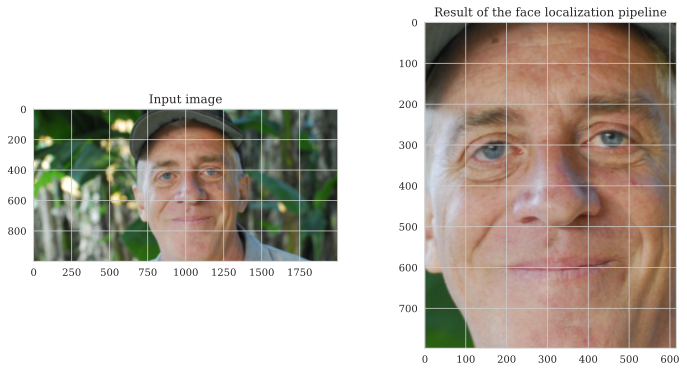

In [ ]:
fig, (ax_orig, ax_crop) = plt.subplots(1, 2, figsize = (12, 6))

img_orig = imread(face_bbox_dict[random_subj]["path_to_image"])
ax_orig.imshow(img_orig)
ax_orig.set_title("Input image")

# extract the bounding box from the first face
mtcnn_output_dict = face_bbox_dict[random_subj]["mtcnn_output_dict"]
x1, y1, width, height = mtcnn_output_dict['box']
x1, y1 = abs(x1), abs(y1)
x2, y2 = x1 + width, y1 + height

# crop the face
img_face = img_orig[y1:y2, x1:x2]

ax_crop.imshow(img_face)
_ = ax_crop.set_title("Result of the face localization pipeline")

---

# FaceAge Estimation

We can then predict the apparent age of the subject whose face has been localized by the previous step, using the FaceAge CNN we developed.

For additional information about the model, please refer to our publication or the project GitHub repository.

In [ ]:
def get_model_prediction(model, path_to_image, mtcnn_output_dict):
  
  # sanity check
  assert os.path.exists(path_to_image)

  pat_img = imread(path_to_image)

  # extract the bounding box from the first face
  x1, y1, width, height = mtcnn_output_dict['box']
  x1, y1 = abs(x1), abs(y1)
  x2, y2 = x1 + width, y1 + height

  # crop the face
  pat_face = pat_img[y1:y2, x1:x2]

  # resize cropped image to the model input size
  pat_face_pil = PIL.Image.fromarray(np.uint8(pat_face)).convert('RGB')
  pat_face = np.asarray(pat_face_pil.resize((160, 160)))
  
  # prep image for TF processing
  mean, std = pat_face.mean(), pat_face.std()
  pat_face = (pat_face - mean) / std
  pat_face_input = pat_face.reshape(1, 160, 160, 3)
  
  return np.squeeze(model.predict(pat_face_input))

In [ ]:
model_path = os.path.join(BASE_MODEL_PATH, "faceage_model.h5")
model = keras.models.load_model(model_path)

In [ ]:
age_pred_dict = dict()

t = time.time()

for idx, subj_id in enumerate(face_bbox_dict.keys()):

  clear_output(wait = True)

  print('(%g/%g) Running the age estimation step for "%s"'%(idx + 1,
                                                              len(face_bbox_dict),
                                                              subj_id))
        
  path_to_image = face_bbox_dict[subj_id]["path_to_image"]
  mtcnn_output_dict = face_bbox_dict[subj_id]["mtcnn_output_dict"]

  age_pred_dict[subj_id] = dict()

  age_pred_dict[subj_id]["faceage"] = get_model_prediction(model, path_to_image, mtcnn_output_dict)
  age_pred_dict[subj_id]["age"] = face_bbox_dict[subj_id]["age"]
  age_pred_dict[subj_id]["gender"] = face_bbox_dict[subj_id]["gender"]
  age_pred_dict[subj_id]["race"] = face_bbox_dict[subj_id]["race"]

elapsed = time.time() - t
print("\n... Done in %g seconds."%(elapsed))

(2547/2547) Running the age estimation step for "20170117152131106"

... Done in 253.806 seconds.


---

Let us inspect the results of the age estimation model (and thus of the whole FaceAge pipeline).

The predicted quantity should reflect the biologic age of the subject (estimated from the face localized by the previous step):

In [ ]:
# example of the final dictionary to be converted into a DataFrame
age_pred_dict[random_subj]

{'age': '62',
 'faceage': array(63.252663, dtype=float32),
 'gender': '0',
 'race': '0'}

In [ ]:
age_pred_df = pd.DataFrame.from_dict(age_pred_dict, orient = 'index')
age_pred_df.reset_index(level = 0, inplace = True)
age_pred_df.rename(columns = {"index": "subj_id"}, inplace = True)

In [ ]:
age_pred_df

,subj_id,faceage,age,gender,race
0,20170110153238490,75.026596,74,1,0
1,20170109213056053,28.754328,21,1,2
2,20170117012906285,48.943573,38,0,1
3,20170117151304315,30.146166,30,1,0
4,20170116200714834,45.974422,26,0,1
...,...,...,...,...,...
2542,20170117165048545,48.71622,55,0,1
2543,20170117182534670,60.842632,35,1,0
2544,20170117194914689,68.6251,63,0,0
2545,20170117175135184,25.377224,26,1,2


In [ ]:
outfile_name = 'utk_hi-res_qa_res.csv'
outfile_path = os.path.join(BASE_OUTPUT_PATH, outfile_name) 
age_pred_df.to_csv(outfile_path, index = False)

Finally, let us visualize and analyze these results (`extended_data_plots_demo.ipynb` notebook).